In [1]:
import glob, os, random
import keras
import numpy as np
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/andri/Projects/Python/virtualenvs/tf1-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andri/Projects/Python/virtualenvs/tf1-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andri/Projects/Python/virtualenvs/tf1-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qi

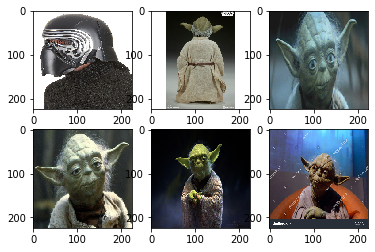

In [2]:
# Adjust these
NAMES = ["BB8", "Kylo_Ren", "Yoda"]
NUM_CLASSES = len(NAMES)
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
TRAINING_DIR = 'dataset/train'
VALIDATION_DIR = 'dataset/valid'
TEST_DIR = 'dataset/test'

img_list = glob.glob(os.path.join(TRAINING_DIR, '*/*.jpg'))
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [5]:
train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True,
#     validation_split=0.1
    preprocessing_function=preprocess_input
)

valid_datagen = ImageDataGenerator(
#     rescale=1./255,
#     validation_split=0.1
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=16,
    class_mode='categorical',
    seed=0,
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=16,
    class_mode='categorical',
    seed=0,
    shuffle=True
)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(
                        TEST_DIR,
                        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
                        batch_size=15,
                        class_mode='categorical',
                        shuffle=False
                 )

print(test_generator.classes)
print(test_generator.class_indices)

Found 85 images belonging to 3 classes.
Found 28 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2]
{'BB8': 0, 'Kylo_Ren': 1, 'Yoda': 2}


In [6]:
# Create base model. It's modified mobilenet
base_model=keras.applications.mobilenet.MobileNet(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), alpha = 0.75,depth_multiplier = 1, dropout = 0.001,include_top = False, weights = "imagenet")
base_model.summary()

Model: "mobilenet_0.75_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 24)      648       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 24)      96        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 24)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 24)      216       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 24

In [7]:
# Additional Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x=Dense(128,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
# x=Dropout(0.6)(x)

# x=Dense(64, activation='relu')(x) #dense layer 3
#preds = Dense(NUM_CLASSES, activation='sigmoid')(x) #final layer with softmax activation
x=Dropout(0.001)(x)
preds = Dense(NUM_CLASSES, activation='softmax')(x) #final layer with softmax activation


model = Model(inputs=base_model.input, outputs=preds)

In [8]:
# base_model.trainable = False

for i,layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
    
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

0 input_1 False
1 conv1_pad True
2 conv1 True
3 conv1_bn True
4 conv1_relu True
5 conv_dw_1 True
6 conv_dw_1_bn True
7 conv_dw_1_relu True
8 conv_pw_1 True
9 conv_pw_1_bn True
10 conv_pw_1_relu True
11 conv_pad_2 True
12 conv_dw_2 True
13 conv_dw_2_bn True
14 conv_dw_2_relu True
15 conv_pw_2 True
16 conv_pw_2_bn True
17 conv_pw_2_relu True
18 conv_dw_3 True
19 conv_dw_3_bn True
20 conv_dw_3_relu True
21 conv_pw_3 True
22 conv_pw_3_bn True
23 conv_pw_3_relu True
24 conv_pad_4 True
25 conv_dw_4 True
26 conv_dw_4_bn True
27 conv_dw_4_relu True
28 conv_pw_4 True
29 conv_pw_4_bn True
30 conv_pw_4_relu True
31 conv_dw_5 True
32 conv_dw_5_bn True
33 conv_dw_5_relu True
34 conv_pw_5 True
35 conv_pw_5_bn True
36 conv_pw_5_relu True
37 conv_pad_6 True
38 conv_dw_6 True
39 conv_dw_6_bn True
40 conv_dw_6_relu True
41 conv_pw_6 True
42 conv_pw_6_bn True
43 conv_pw_6_relu True
44 conv_dw_7 True
45 conv_dw_7_bn True
46 conv_dw_7_relu True
47 conv_pw_7 True
48 conv_pw_7_bn True
49 conv_pw_7_relu True


In [9]:
# Fine tune from this layer onwards
fine_tune_at = 86
# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
  layer.trainable =  False

for layer in model.layers[fine_tune_at:]:
  layer.trainable =  True

# for layer in base_model.layers:
#   layer.trainable =  False

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 24)      648       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 24)      96        
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 24)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 24)      216       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 24)      96  

In [11]:
# model.compile(loss='binary_crossentropy',
#               optimizer = keras.optimizers.RMSprop(lr=1e-5),
#               #optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
#               metrics=['accuracy'])

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=0.0005),
#               optimizer='Adam',
              metrics=['accuracy'])

In [22]:
batch_size = 16
epochs = 30
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size
print("Step/epoch: {}, val steps: {}".format(steps_per_epoch, validation_steps))

checkpoint_cb = keras.callbacks.ModelCheckpoint(
                filepath='./out_models/best_model.{epoch:02d}-{val_loss:.2f}.h5',
                monitor='val_loss', save_best_only=True)

tensorboard_cb = keras.callbacks.TensorBoard(log_dir='./tensorboard',
                                            #histogram_freq=2,
                                            batch_size=train_generator.batch_size,
                                            write_grads=True,
                                            write_graph=False,
                                            update_freq='batch')

earlystop_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=5)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs, 
                              workers=4,                              
                              validation_data=validation_generator, 
                              validation_steps=validation_steps,
                              callbacks=[checkpoint_cb]
                              )

Step/epoch: 5, val steps: 1
Epoch 1/30
5/5 [==============================] - 3s 567ms/step - loss: 0.2232 - accuracy: 0.9710 - val_loss: 0.1003 - val_accuracy: 1.0000
Epoch 2/30
5/5 [==============================] - 2s 479ms/step - loss: 0.2575 - accuracy: 0.9130 - val_loss: 0.1789 - val_accuracy: 0.9167
Epoch 3/30
5/5 [==============================] - 3s 556ms/step - loss: 0.1404 - accuracy: 0.9625 - val_loss: 0.0588 - val_accuracy: 1.0000
Epoch 4/30
5/5 [==============================] - 2s 465ms/step - loss: 0.0848 - accuracy: 1.0000 - val_loss: 0.1170 - val_accuracy: 1.0000
Epoch 5/30
5/5 [==============================] - 2s 499ms/step - loss: 0.1038 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 1.0000
Epoch 6/30
5/5 [==============================] - 2s 445ms/step - loss: 0.1414 - accuracy: 0.9855 - val_loss: 0.0747 - val_accuracy: 1.0000
Epoch 7/30
5/5 [==============================] - 3s 509ms/step - loss: 0.1049 - accuracy: 1.0000 - val_loss: 0.0580 - val_accuracy:

In [13]:
model.save('starwars.h5')

In [16]:
# Predictions
from keras.models import load_model
# Choose the best model
model_file = 'out_models/best_model.22-0.02.h5'
model = load_model(model_file)

In [24]:
predictions = model.predict_generator(test_generator)
print(predictions)
predictions.argmax(axis=1)

[[6.05691075e-01 3.88615012e-01 5.69390599e-03]
 [9.79867220e-01 8.09653103e-03 1.20362844e-02]
 [9.84567881e-01 6.39377115e-03 9.03831515e-03]
 [9.77831602e-01 1.96713135e-02 2.49713729e-03]
 [6.56768799e-01 3.39755952e-01 3.47519806e-03]
 [9.43211257e-01 5.59947528e-02 7.93954823e-04]
 [6.28735721e-01 3.65323216e-01 5.94110321e-03]
 [9.97267723e-01 2.69837072e-03 3.38656027e-05]
 [9.77153182e-01 1.83358751e-02 4.51092841e-03]
 [9.81390595e-01 1.70306303e-02 1.57876185e-03]
 [7.93757677e-01 1.62692577e-01 4.35497724e-02]
 [9.79361236e-01 1.89980082e-02 1.64074858e-03]
 [8.23951885e-03 9.91409719e-01 3.50769958e-04]
 [4.36125032e-04 9.94659126e-01 4.90469951e-03]
 [4.81441757e-03 9.95050251e-01 1.35312352e-04]
 [5.19901747e-03 9.94469047e-01 3.31981282e-04]
 [2.99718115e-03 9.94891286e-01 2.11161608e-03]
 [4.63944487e-02 9.53205943e-01 3.99626937e-04]
 [3.16978944e-03 1.31622525e-02 9.83667910e-01]
 [8.68558958e-02 1.37727663e-01 7.75416434e-01]
 [4.15070578e-02 2.64082313e-01 6.944106

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2])

In [16]:
def plot_cm(cM, labels, title):
    # normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.sum(axis=1)[:,None])*100,2)
    # creating a figure object
    fig = plt.figure()
    # plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation=None,cmap = plt.cm.Blues)
    # creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    # assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '\n% confidence')
    # defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    # number of occurences in the boxes
    width, height = cM.shape 
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:d}'.format(int(cmNormalized[predicted,real])),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)
    # making sure that the figure is not clipped
    plt.tight_layout()
    # saving the figure
    fig.savefig(title +'.png')

In [17]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2], dtype=int32)

In [25]:
from sklearn import metrics

cm_plot_labels = ['BB8', 'Kylo_Ren', 'Yoda']
cm = metrics.confusion_matrix(test_generator.classes, predictions.argmax(axis=1))


Accuracy for each class is given below.
BB8         : 100.0 %
Kylo_Ren    : 100.0 %
Yoda        : 100.0 %


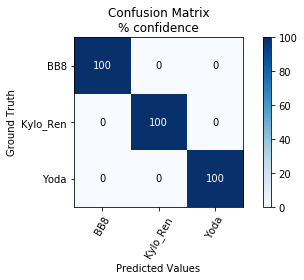

In [26]:
plot_cm(cm, cm_plot_labels, 'Confusion Matrix')

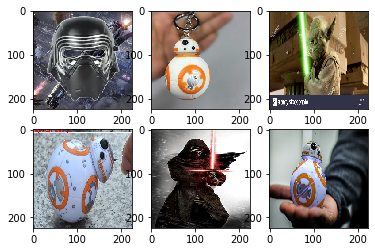

In [42]:
# Test
img_list = glob.glob(os.path.join(TEST_DIR, '*/*.jpg'))
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

dataset/test/Kylo_Ren/32.jpg


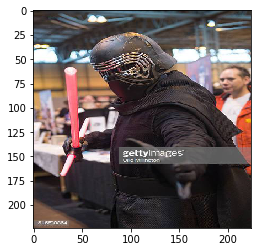

In [43]:
random_test_img_path = random.sample(img_list, 10)[0]
print(random_test_img_path)

test_img = image.load_img(random_test_img_path, target_size=(224, 224))

test_img_array_show = image.img_to_array(test_img, dtype=np.uint8)
plt.subplot(1, 1, 1)
plt.imshow(test_img_array_show.squeeze())


test_img_array = image.img_to_array(test_img)
test_img_array_expanded_dims = np.expand_dims(test_img_array, axis=0)

In [44]:
preproc_test_img_input = keras.applications.mobilenet.preprocess_input(test_img_array_expanded_dims)
test_predictions = model.predict(preproc_test_img_input)

for i, label in enumerate(NAMES):
    print("{0} -> {1:.2f}%".format(label, test_predictions[0][i]*100))
    
tes_pred_idx = np.argmax(test_predictions, axis=1)[0]
print("\nPrediction class: {:d} - {}".format(tes_pred_idx, NAMES[tes_pred_idx]))

BB8 -> 0.48%
Kylo_Ren -> 99.51%
Yoda -> 0.01%

Prediction class: 1 - Kylo_Ren
